## Notebook Purpose

Debugged issue with ground-truth reconstruction. Turns out that fastMRI test set only provides undersampled k-space. To get full k-space, must use validation set

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils.helpers import load_h5, get_masks
from utils.transform import np_to_tt, apply_mask, ifft_2d,\
                            reshape_complex_channels_to_be_adj,\
                            combine_complex_channels, crop_center,\
                            root_sum_of_squares
from include.mri_helpers import get_scale_factor

In [2]:
def recon_ksp_to_img(ksp, dim=320):
    ''' given a 3D npy array (or torch tensor) ksp k-space e.g. shape (15,x,y)
        (1) perform ifft to img space
        (2) reshape/combine complex channels
        (3) combine multiple coils via root sum of squares
        (4) crop center portion of image according to dim
    '''

    if type(ksp).__module__ == np.__name__:
        ksp = np_to_tt(ksp)

    arr = ifft_2d(ksp).cpu().numpy()
    arr = reshape_complex_channels_to_be_adj(arr)
    
#     plt.hist(arr.flatten())
    arr = combine_complex_channels(arr) # e.g. shape (30,x,y) --> (15,x,y)
    arr = root_sum_of_squares(arr) # e.g. (15,x,y) --> (x,y)
    
    arr = crop_center(arr, dim, dim) # e.g. (x,y) --> (dim,dim)

    return arr

### Questions to answer

- Are we zeroing out some information when combining complex channels or when performing rss operation?
    - No - np.count_nonzero() returns same value for each step
    - Scaling dynamic range to [0,255] doesn't help
- Because I'm taking from test set, perhaps the k-space is already undersampled? e.g. test to see if applying the mask makes a difference in number of non-zeros
    - Test 1: applying mask makes a very small difference - e.g. <1% of non-zero values become zero when mask is applied
    - Test 2: when plotting boolean k-space, it sure looks as if the values have already been zeroed

### Load sample

In [3]:
def load_h5(file_id, slice_idx_from_last=None):
    ''' given file_id, return the h5 file and central slice '''

    VAL = True
    
    if VAL:
        direc, v2 = 'multicoil_val', ''
        v2 = ''
    else:
        direc, v2 = 'multicoil_test_v2', '_v2'
    filename = '/bmrNAS/people/dvv/{}/file{}{}.h5'.format(direc, file_id, v2)
    
    f = h5py.File(filename, 'r')
    #print('file_id {} w ksp shape (num_slices, num_coils, x, y): {}'.format( \
    #                                            file_id, f['kspace'].shape))

    if f['kspace'].shape[3] == 320:
        print('2D slice is length 320 -- may prevent masks from loading properly')

    slice_idx = f['kspace'].shape[0] // 2
    slice_ksp = f['kspace'][slice_idx]

    return f, slice_ksp

In [9]:
# test set
# file_id_list = ['1000411', '1000186', '1000361', '1001524', '1000799', '1001152', '1001132']

# val set
file_id_list = ['1000267', '1000292', '1000254', '1000178']

for file_id in file_id_list:
    
    f, slice_ksp = load_h5(file_id)
    print(slice_ksp.shape)
    
    slice_ksp_tt = np_to_tt(slice_ksp)
    
    mask, mask2d, mask1d = get_masks(f, slice_ksp)
    
    ksp_premask = slice_ksp_tt.cpu().numpy()
    ksp_masked = apply_mask(slice_ksp_tt, mask=mask).cpu().numpy()
    

    # slice_ksp is (15,x,y) w complex entries
    img_gt = recon_ksp_to_img(slice_ksp) # skipped slice_ksp scaling

(15, 640, 400)
under-sampling factor: 4.17
torch.Size([1, 1, 400, 1]) (640, 400) (400,)
(15, 640, 372)
under-sampling factor: 3.58
torch.Size([1, 1, 372, 1]) (640, 372) (372,)
(15, 640, 372)
under-sampling factor: 3.84
torch.Size([1, 1, 372, 1]) (640, 372) (372,)
(15, 640, 372)
under-sampling factor: 3.65
torch.Size([1, 1, 372, 1]) (640, 372) (372,)


In [10]:
# how much of a difference does it make to apply the mask?
masked_out = np.count_nonzero(ksp_premask) - np.count_nonzero(ksp_masked)
size_ksp = ksp_premask.size
perc_pre_mask = np.count_nonzero(ksp_premask) / size_ksp
perc_post_mask = np.count_nonzero(ksp_masked) / size_ksp
print('% nonzeros pre-mask: {}, post-mask: {}. num zeroed: {}'.format(\
            np.round(perc_pre_mask,4), np.round(perc_post_mask,4), masked_out))

% nonzeros pre-mask: 0.9005, post-mask: 0.2554. num zeroed: 4607807


In [121]:
ksp_pre = np_to_tt(slice_ksp)

print(mask.shape, ksp_pre.shape)

out = ksp_pre * mask
out.shape

torch.Size([1, 1, 372, 1]) torch.Size([15, 640, 372, 2])


torch.Size([15, 640, 372, 2])

In [122]:
def plot_boolean_kspace(ksp):
    ''' plot kspace whether values have been zeroed out or not '''
    
    ksp_pre_comb = combine_complex_channels(reshape_complex_channels_to_be_adj(ksp.numpy()))
    ksp_pre_cut = ksp_pre_comb[9, :50, :]

    ksp_boo = ksp_pre_cut > 0
    ksp_boo = ksp_boo.astype(int)

    plt.figure(figsize=(16, 16))
    plt.imshow(ksp_boo, cmap='gray')
    plt.show()

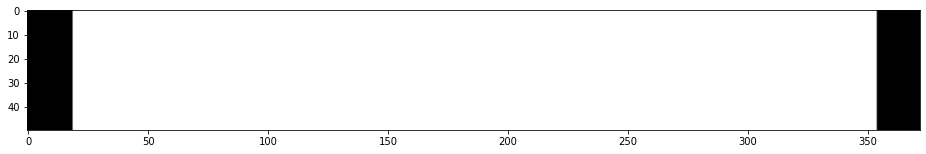

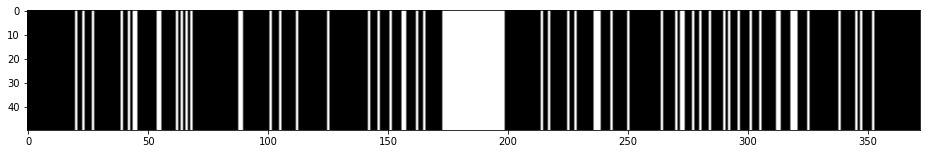

In [123]:
plot_boolean_kspace(ksp_pre)
plot_boolean_kspace(out)